# Best Available Pixel Composite in OpenEO (experimental)

In this notebook a composite image is created based on the Best Available Pixel (BAP) method in OpenEO. The BAP score is calculated via using a UDF, which gives a lot of flexibility on the calculation methodology. The BAP score is a weighted average of three scores:
- **Distance-to-Cloud Score**: Pixels that are clouds are given score 0. Pixels that are moren than 50 pixels - calculated with the Manhattan distance measure - away from a cloud pixel are given score 1. The pixels in between are given a score versus distance-to-cloud that follows a Gaussian shape.
- **Coverage Score**: Per date, the percentage of all pixels that are classified as a cloud over the entire spatial extent is calculated. The Coverage Score is then equal to 1 - the cloud percentage.
- **Date Score**: In order to favor pixels that are observed in the middle of a month, a date score is calculated, which follows a Gaussian shape. I.e. the largest scores are given for days in the middle of the month, the lowest scores are given for days at the beginning and end of the month. 

The final BAP score is a weighted average of the three aforementioned scores. The weights are 1, 0.5 and 0.8 for the Distance-to-Cloud, Coverage and Date Score respectively. 

In this notebook the BAP score is calculated by using only OpenEO pre-defined processes. As of right now, it is not possible to calculate the Coverage Score this way, so the final result of this notebook is the combination of the Distance-to-Cloud and Date Score. In another notebook, the BAP score is calculated via a UDF, which allows for the coverage score to be included, along with some other extra flexibility. This notebook is still experimental.

First a sample period and region are defined.

In [1]:
# Enter the bbox coordinates (epsg:4326)
WEST = 4.45
EAST = 4.50
SOUTH = 51.16
NORTH = 51.17

In [2]:
spatial_extent = {'west': WEST, 'east': EAST, 'south': SOUTH, 'north': NORTH, 'crs': 'epsg:4326'}
temporal_extent = ["2022-06-04", "2022-08-01"]
max_cloud_cover = 90
spatial_resolution = 20

In [3]:
import openeo
import xarray
import numpy as np

from openeo.processes import if_, is_nan

In [5]:
c=openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


In [6]:
scl = c.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=spatial_extent,
    temporal_extent=temporal_extent,
    bands=["SCL"],
    max_cloud_cover=max_cloud_cover
).resample_spatial(spatial_resolution)

Next, make sure that all pixels which are NaN are cast to zero. This is necessary for later.

In [7]:
scl = scl.apply(lambda x: if_(is_nan(x), 0, x))

Next, a binary is created where all pixels identified as clouds in the SCL layer are set to 1, all others are set to 0.

In [8]:
classification = scl.band("SCL")
binary = (classification == 3) | (classification == 8) | (classification == 9) | (classification == 10)

## Date Score

Next, for each pixel, the day of the month is 'calculated' in order to obtain the date score. Since there is no pre-defined process in OpenEO to do this directly, the following method is used. First the 'date_replace_component' process is used to change the day in the date to the 15th of the month. For example, "2021-03-31" is replaced by "2021-03-15". Next, using the 'date_difference' process the difference between the day of the original date and the day of the replaced date is calculated. For example, for "2021-03-31", this would be the difference in days between "2021-03-31" and "2021-03-15", i.e. 16. Afterwards 15 is added to this number in order to obtain the actual day of the month. In this algorithm, 15 is just an arbitrary number. 

In [9]:
from openeo.api.process import Parameter

label = Parameter('label')

def day_of_month_calc(input):    
    day = lambda x:15 + x.process("date_difference",date1=x.process("date_replace_component",date=label,value=15,component="day"),date2=label,unit="day") 
    return input.array_apply(day)  

def date_score(day):
    return day.subtract(15).multiply(0.2).multiply(day.subtract(15).multiply(0.2)).multiply(-0.5).exp().multiply(0.07978845)  # Until 'power' and 'divide' are fixed, use this workaround

day_of_month = scl.apply_neighborhood(
        day_of_month_calc,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

date_score = (1.0 * day_of_month).apply(date_score)
date_score = date_score.rename_labels('bands', ['score'])

C:\Users\VERELSTV\OneDrive - VITO\Documents\OpenEO Python Client\openeo-python-client\openeo\api\process.py:22: UserWarning: Parameter without description: using name as description.
  warnings.warn("Parameter without description: using name as description.")


## Coverage Score (WIP)

As of right now, the coverage score is still work in progress. No coverage score is calculate, and this section can be skipped.

In [ ]:
# aoi_polygon = {"type": "FeatureCollection", "features": [
#     {
#         "type": "Feature", "properties": {},
#         "geometry": {"type": "Polygon", "coordinates": [[
#             [WEST, SOUTH], [WEST, NORTH], [EAST, NORTH], [EAST, SOUTH], [WEST, SOUTH]
#         ]]}
#     }
# ]}

In [ ]:
# The cloud coverage percentage is just the average of the binary 
# cloud_coverage = binary.aggregate_spatial(geometries = aoi_polygon, reducer = 'mean')  # Still need to convert this to 1 - ...

In [ ]:
# cloud_coverage.download('results/cloud_coverage.json')

In [ ]:
# cloud_coverage_raster = cloud_coverage.process("vector_to_raster", data=cloud_coverage, target_data_cube=scl)

In [ ]:
# cloud_coverage_raster.download('results/cloud_coverage.nc')

In [ ]:
# cloud_coverage_ds = xarray.open_dataset('results/cloud_coverage.nc')
# cloud_coverage_ds
# # cloud_coverage_ds['band_0'].values  #.plot(vmin=0,vmax=1,col="t",col_wrap=4)

## Distance to Cloud Score

Finally, the Distance to Cloud Score is calculated by applying a Gaussian kernel to the binary.
The kernel size, defined below, indicates the maximum distance from a cloud, above which a pixel is automatically assigned score 1. In case of a kernel size of 51, the maximum distance is 50 pixels.

In [10]:
kernel_size = 51

Next, a Gaussian kernel is constructed. In this case it is a 51x51 matrix. The kernel is also normalized, to make sure the resulting score is not higher than 1.

In [11]:
from scipy.signal.windows import gaussian

gaussian_1d = gaussian(M=kernel_size, std=1)
gaussian_kernel= np.outer(gaussian_1d, gaussian_1d)
gaussian_kernel /= gaussian_kernel.sum()

In [12]:
cloud_score = 1 - binary.apply_kernel(gaussian_kernel)
cloud_score = cloud_score.add_dimension(name = 'bands', label = 'score', type = 'bands')

## Aggregating Scores

Then, the scores are aggregated together. As for now the coverage score is excluded. To make sure that pixels which contain no data (SCL score 0) are not selected, they are explicitly masked out of the final score.

In [13]:
weights = [1, 0.8, 0.5]
# score = (weights[0] * cloud_score + weights[1] * date_score + weights[2] * coverage_score) / sum(weights)
score = (weights[0] * cloud_score + weights[1] * date_score) / (weights[0] + weights[1]) 
score = score.mask(classification == 0)

And once again, the score can be downloaded and plotted for inspection.

In [14]:
score.download('results/score.nc')

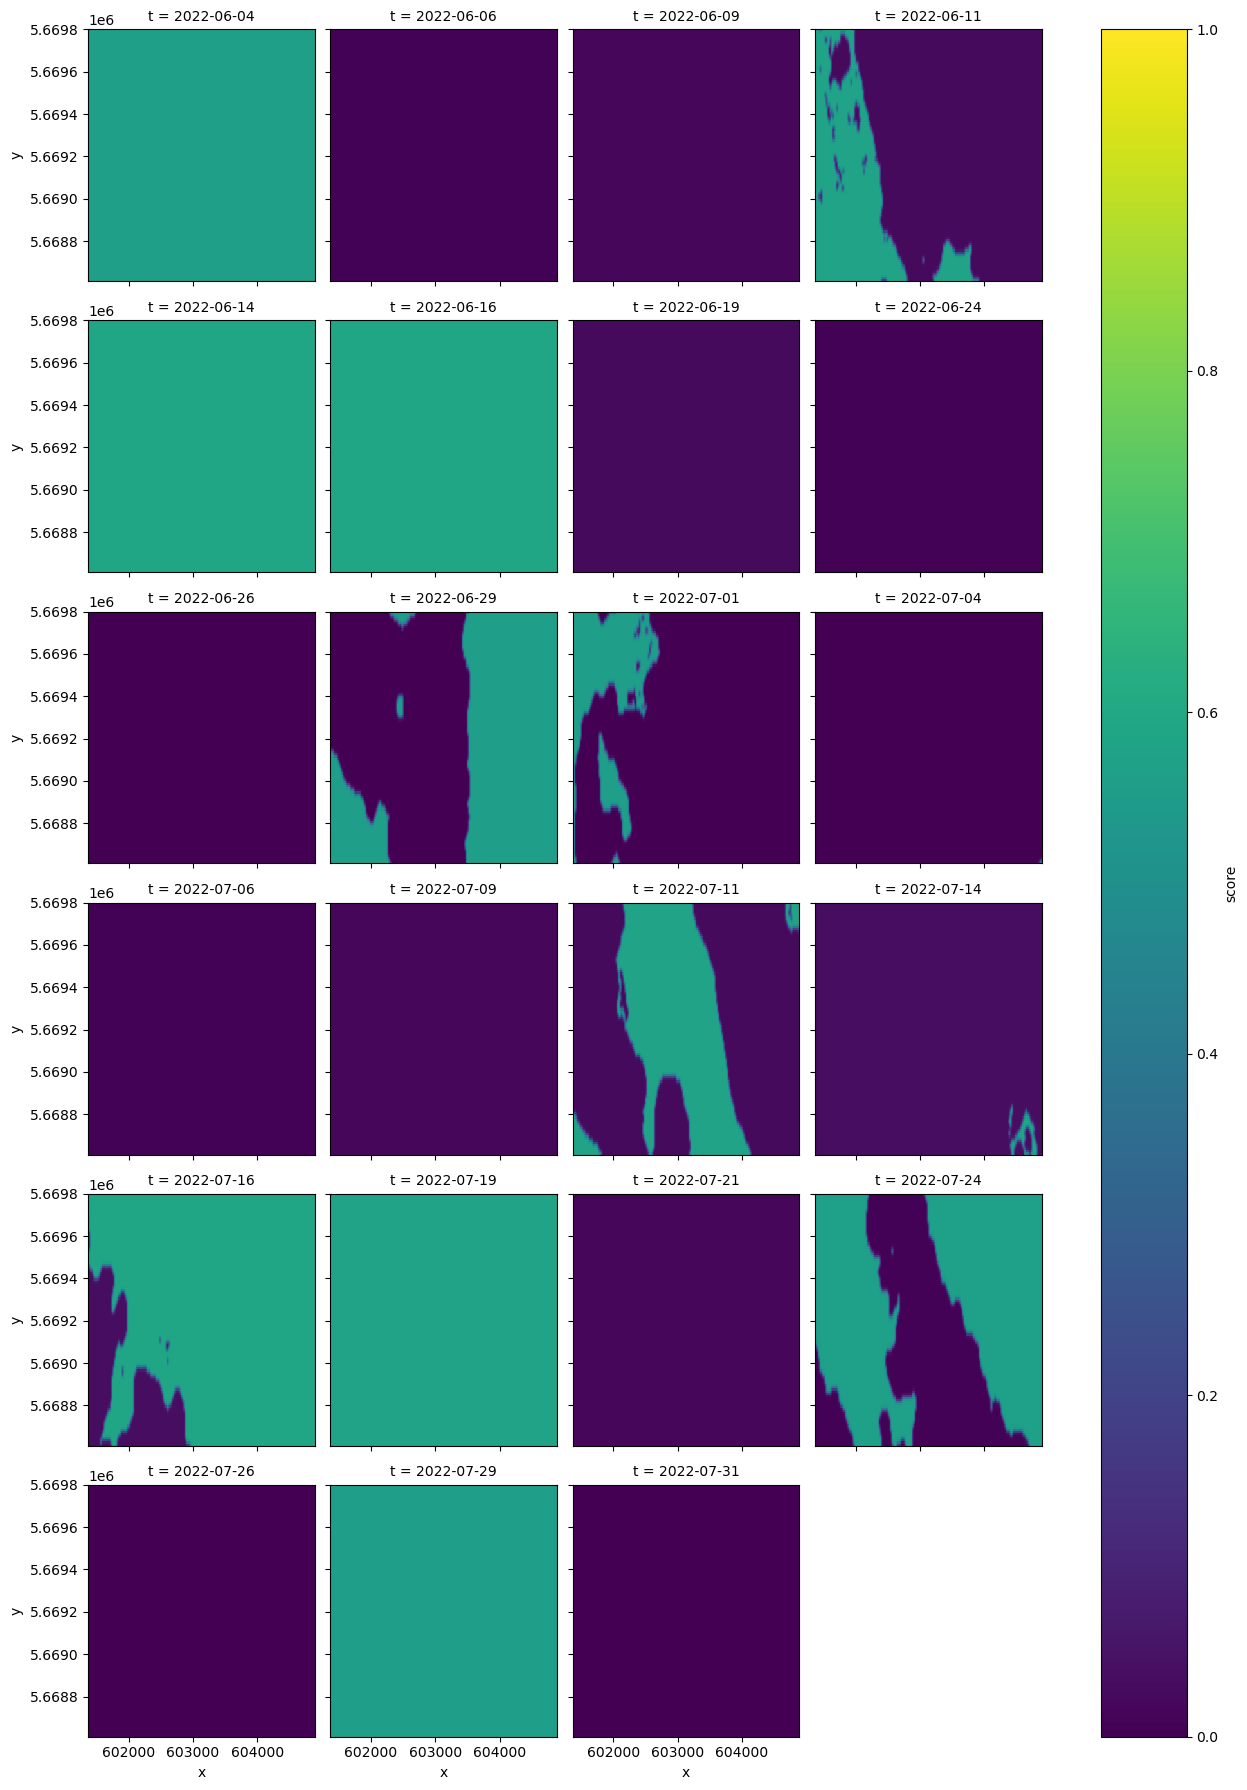

In [15]:
score_ds = xarray.open_dataset('results/score.nc')
score_ds['score'].plot(vmin=0,vmax=1,col="t",col_wrap=4)

## Masking and Compositing

Next, a mask is created. This serves to mask every pixel, except the one with the highest score, for each month.

In [16]:
def max_score_selection(score):
    max_score = score.max()
    return score.array_apply(lambda x:x!=max_score)

rank_mask = score.apply_neighborhood(
        max_score_selection,
        size=[{'dimension': 'x', 'unit': 'px', 'value': 1}, {'dimension': 'y', 'unit': 'px', 'value': 1},
              {'dimension': 't', 'value': "month"}],
        overlap=[]
    )

rank_mask = rank_mask.band('score')

Next, some bands of interest from Sentinel-2 are loaded. They are then masked by the BAP mask constructed above. Then they are aggregated per month, to obtain a composite image per month. By using the "first" process as an aggregator, the situation where there are potentially more than one days in a month selected by the algorithm is immediately handled.

In [17]:
rgb_bands = c.load_collection(
    "SENTINEL2_L2A",
    temporal_extent = temporal_extent,
    spatial_extent = spatial_extent,
    bands = ["B02", "B03","B04"],
    max_cloud_cover=max_cloud_cover
).resample_spatial(spatial_resolution)

composite = rgb_bands.mask(rank_mask.resample_cube_spatial(rgb_bands)).aggregate_temporal_period("month","first")

Next, the final results are downloaded and a composite image for the month of June is shown as an example.

In [18]:
composite.download('./results/composite_process.nc')

In [19]:
composite_ds = xarray.open_dataset('./results/composite_process.nc')
composite_ds

<xarray.Dataset>
Dimensions:  (t: 2, x: 352, y: 119)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-01 2022-07-01
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
Data variables:
    crs      |S1 ...
    B02      (t, y, x) float32 ...
    B03      (t, y, x) float32 ...
    B04      (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

In [20]:
rgb_array=composite_ds.to_array(dim="bands").sel(bands=["B04","B03","B02"]).astype(np.float32)/10000
rgb_array

<xarray.DataArray (bands: 3, t: 2, y: 119, x: 352)>
array([[[[0.1052, 0.1026, 0.0934, ..., 0.0836, 0.0924, 0.1092],
         [0.0951, 0.0937, 0.091 , ..., 0.1268, 0.1338, 0.153 ],
         [0.094 , 0.0934, 0.0944, ..., 0.13  , 0.1238, 0.1384],
         ...,
         [0.115 , 0.1158, 0.0732, ..., 0.0229, 0.0258, 0.0352],
         [0.0726, 0.0626, 0.0646, ..., 0.0215, 0.0238, 0.031 ],
         [0.0532, 0.0518, 0.0664, ..., 0.0225, 0.023 , 0.0264]],

        [[0.0948, 0.1064, 0.0737, ..., 0.0932, 0.103 , 0.1158],
         [0.0976, 0.0994, 0.0982, ..., 0.1374, 0.1406, 0.156 ],
         [0.0956, 0.1016, 0.111 , ..., 0.1452, 0.1296, 0.1368],
         ...,
         [0.1172, 0.107 , 0.0854, ..., 0.0213, 0.0233, 0.0326],
         [0.08  , 0.0678, 0.069 , ..., 0.022 , 0.0211, 0.0276],
         [0.0763, 0.0676, 0.0609, ..., 0.0202, 0.0208, 0.0212]]],


       [[[0.098 , 0.0972, 0.112 , ..., 0.0836, 0.0916, 0.1068],
         [0.0932, 0.0885, 0.0889, ..., 0.1144, 0.1252, 0.146 ],
         [0.0863, 0.0894, 0.0908, ..., 0.1206, 0.124 , 0.1372],
...
         [0.0882, 0.0874, 0.0882, ..., 0.0435, 0.0452, 0.0552],
         [0.0841, 0.0812, 0.084 , ..., 0.042 , 0.046 , 0.0477]]],


       [[[0.076 , 0.0776, 0.0988, ..., 0.0697, 0.07  , 0.0792],
         [0.085 , 0.0774, 0.0692, ..., 0.106 , 0.1032, 0.1096],
         [0.0781, 0.0813, 0.0858, ..., 0.1036, 0.0941, 0.1108],
         ...,
         [0.0894, 0.1009, 0.0596, ..., 0.0232, 0.026 , 0.0336],
         [0.0581, 0.0454, 0.0493, ..., 0.0221, 0.0253, 0.026 ],
         [0.0429, 0.0431, 0.0553, ..., 0.0222, 0.0241, 0.0218]],

        [[0.0675, 0.0836, 0.0612, ..., 0.0688, 0.0786, 0.0913],
         [0.0862, 0.0874, 0.084 , ..., 0.1142, 0.1118, 0.1184],
         [0.0826, 0.0896, 0.0946, ..., 0.1122, 0.1028, 0.1102],
         ...,
         [0.1118, 0.1094, 0.0802, ..., 0.0211, 0.0213, 0.0284],
         [0.0788, 0.0736, 0.073 , ..., 0.0197, 0.0181, 0.0226],
         [0.08  , 0.0652, 0.0688, ..., 0.0202, 0.0198, 0.0227]]]],
      dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 2022-06-01 2022-07-01
  * x        (x) float64 6.014e+05 6.014e+05 6.014e+05 ... 6.049e+05 6.049e+05
  * y        (y) float64 5.67e+06 5.67e+06 5.67e+06 ... 5.669e+06 5.669e+06
  * bands    (bands) object 'B04' 'B03' 'B02'

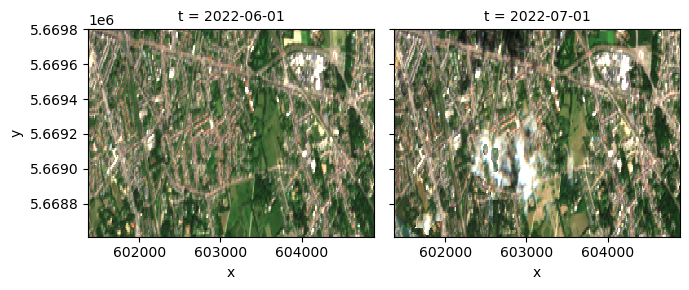

In [21]:
xarray.plot.imshow(rgb_array,vmin=0,vmax=0.18,rgb="bands",col='t',col_wrap=2)